In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Grid:
    def __init__(self, nrows, ncols, pos_start, pos_goal, pos_obstacles, epsilon=0.9, alpha=0.1, 
                 num_episodes=1, learning_method="sarsa"):
        self.nrows = nrows
        self.ncols = ncols
        self.grid = np.zeros((nrows, ncols))
        self.pos_start = pos_start
        self.pos_goal = pos_goal
        self.pos_obstacles = pos_obstacles
        self.epsilon = epsilon
        self.alpha = alpha
        self.num_episodes = num_episodes
        self.learning_method=learning_method
        
        self.UP = 0
        self.RIGHT = 1
        self.DOWN = 2
        self.LEFT = 3
        
        self.set_grid()
        self.Q = self.initialise_q_values()
    
    def set_grid(self):
        self.grid[self.pos_start] = 1
        self.grid[self.pos_goal] = 2
        self.grid[self.pos_obstacles[:, 0], self.pos_obstacles[:, 1]] = 3
        
    def initialise_q_values(self):
        Q = np.random.rand(nrows, ncols, 4)
        Q[self.pos_goal[0], self.pos_goal[1], :] = [0]*4
        
        for i in range(self.nrows):
            for j in range(self.ncols):
                available_actions = self.get_available_actions((i, j))
                for action in range(4):
                    if action not in available_actions:
                        Q[i][j][action] = -10**3
        
        return Q
        
    def get_available_actions(self, state):
        
        assert state[0] >=0 and state[0] < self.nrows, "Row index excedded"
            
        assert state[1] >=0 and state[1] < self.ncols, "Column index excedded"
        
        if state[0] == 0:
            if state[1] == 0:
                return [self.UP, self.RIGHT]
            elif state[1] == self.ncols-1:
                return [self.UP, self.LEFT]
            else:
                return [self.UP, self.RIGHT, self.LEFT]
        elif state[0] == self.nrows - 1:
            if state[1] == 0:
                return [self.RIGHT, self.DOWN]
            elif state[1] == self.ncols-1:
                return [self.DOWN, self.LEFT]
            else:
                return [self.RIGHT, self.DOWN, self.LEFT]    
        elif state[1] == 0:
            return [self.UP, self.RIGHT, self.DOWN]
        elif state[1] == self.ncols - 1:
            return [self.UP, self.DOWN, self.LEFT]
        else:
            return [self.UP, self.RIGHT, self.DOWN, self.LEFT]        
    
    def choose_action(self, state, epsilon):
        available_actions = self.get_available_actions(state)
        while True:
            actions = [0, 1, 2, 3]
            max_q_value_idx = np.argmax(self.Q[state])

            greedy_prob = epsilon + (1.0-epsilon)/len(actions)
            rem_prob = (1.0 - greedy_prob)/(len(actions) - 1)

            probs = [rem_prob]*len(actions)
            probs[max_q_value_idx] = greedy_prob
            chosen_action = np.random.choice(actions, p=probs)
            
            if chosen_action in available_actions:
                return chosen_action
    
    def move(self, state, action):
        new_state = None
        if action == 0:
            new_state = (state[0]+1, state[1])
        elif action == 1:
            new_state = (state[0], state[1]+1)
        elif action == 2:
            new_state = (state[0]-1, state[1])
        else:
            new_state = (state[0], state[1]-1)
            
        return new_state
    
    def get_reward(self, new_state):
        if self.grid[new_state] == 2:
            return 20
        elif self.grid[new_state] == 3:
            return -100
        else:
            return -1
        
    def step(self, start_state):
        print("Learning algorithm: ", self.learning_method)
        if self.learning_method== "sarsa":
            for i in range(self.num_episodes):
                state = start_state
                action = self.choose_action(state, self.epsilon)
                while state != self.pos_goal:
                    new_state = self.move(state, action)
                    reward = self.get_reward(new_state)

                    new_action = self.choose_action(new_state, self.epsilon)

                    old_q_val = self.Q[state][action]
                    updated_q_val = old_q_val + self.alpha*(reward + self.Q[new_state][new_action] - old_q_val)
                    self.Q[state][action] = updated_q_val

                    state = new_state
                    action = new_action
        elif self.learning_method == "q-learning":
            for i in range(self.num_episodes):
                state = start_state
                while state != self.pos_goal:
                    action = self.choose_action(state, self.epsilon)
                    new_state = self.move(state, action)
                    reward = self.get_reward(new_state)

                    new_action = np.argmax(self.Q[new_state])

                    old_q_val = self.Q[state][action]
                    updated_q_val = old_q_val + self.alpha*(reward + self.Q[new_state][new_action] - old_q_val)
                    self.Q[state][action] = updated_q_val

                    state = new_state
                
        print("Learning done!")
        
    def plot_grid(self):
        grid_plot = np.copy(self.grid)
        for i in range(self.nrows):
            for j in range(self.ncols):
                action = np.argmax(self.Q[i][j])
                grid_plot[i][j] = action
                
        return np.flip(grid_plot, axis=0)

In [40]:
def plot_policy(scale, final_grid):
    scale = 0.25
    fig, ax = plt.subplots(figsize=(21, 4))
    for r, row in enumerate(final_grid):
        for c, cell in enumerate(row):
            if cell == 0.0:
                dx, dy = 0, scale
            elif cell == 1.0:
                dx, dy = scale, 0.0
            elif cell == 2.0:
                dx, dy = 0, -scale
            else:
                dx, dy = -scale, 0.0

            plt.arrow(c, final_grid.shape[0]-1-r, dx, dy, head_width=0.1)

In [13]:
nrows, ncols = 4, 21
pos_start = (0,0)
pos_goal = (0, 20)
pos_obstacles = np.array([(0, i) for i in range(1, ncols-1)])
epsilon = 0.9
alpha = 0.3
num_episodes = 10**4

## SARSA

In [14]:
learning_method="sarsa"

sarsa_grid = Grid(nrows, ncols, pos_start, pos_goal, pos_obstacles, epsilon=epsilon, alpha=alpha, 
            num_episodes=num_episodes, learning_method=learning_method)
sarsa_grid.step(pos_start)

Learning algorithm:  sarsa
Learning done!


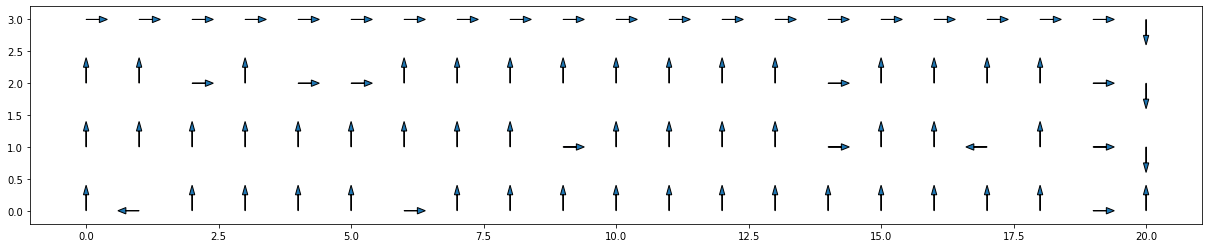

In [42]:
final_sarsa_grid = sarsa_grid.plot_grid()

scale = 0.25
plot_policy(scale, final_sarsa_grid)

## Q-Learning

In [16]:
learning_method="q-learning"

q_learning_grid = Grid(nrows, ncols, pos_start, pos_goal, pos_obstacles, epsilon=epsilon, alpha=alpha, 
            num_episodes=num_episodes, learning_method=learning_method)
q_learning_grid.step(pos_start)

Learning algorithm:  q-learning
Learning done!


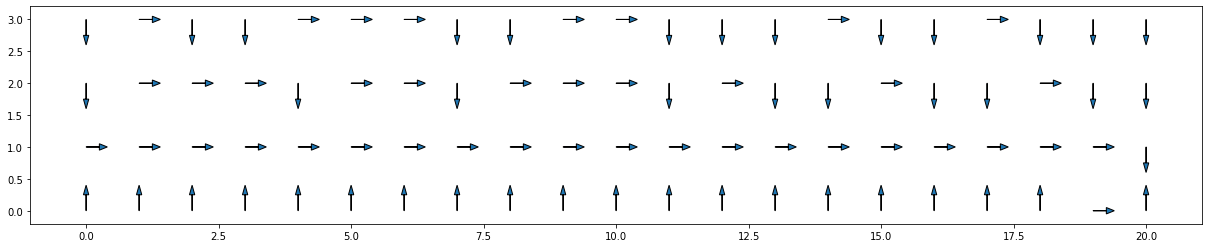

In [43]:
final_q_learning_grid = q_learning_grid.plot_grid()

scale = 0.25
plot_policy(scale, final_q_learning_grid)